<a href="https://colab.research.google.com/github/Tejaswini-AnalyticsExpert/Supply-Chain-Management/blob/main/Location_Wise_Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

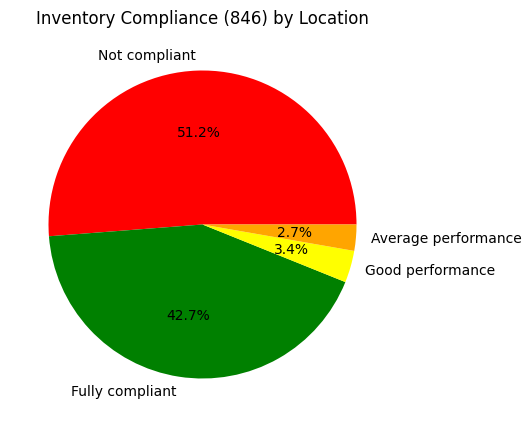

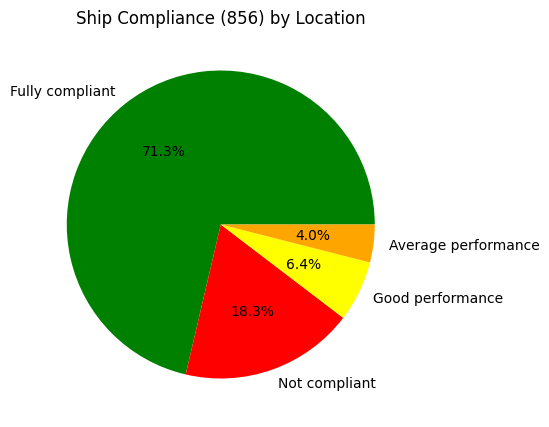

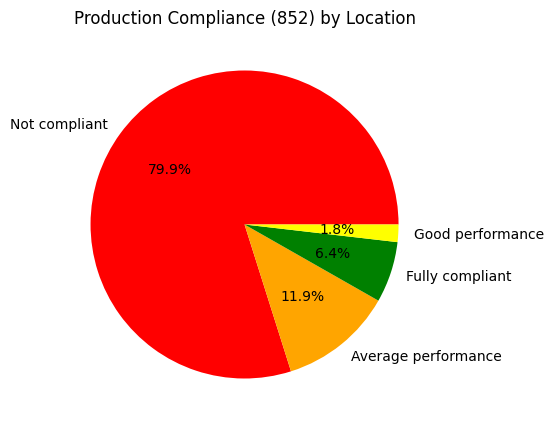

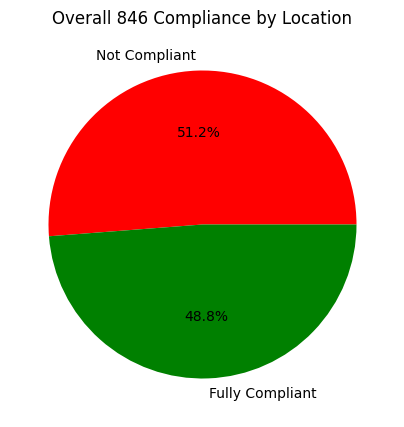

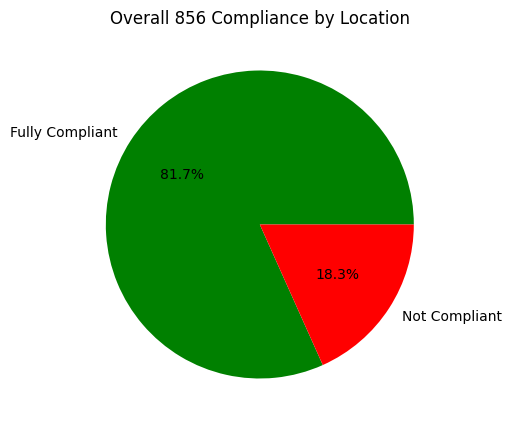

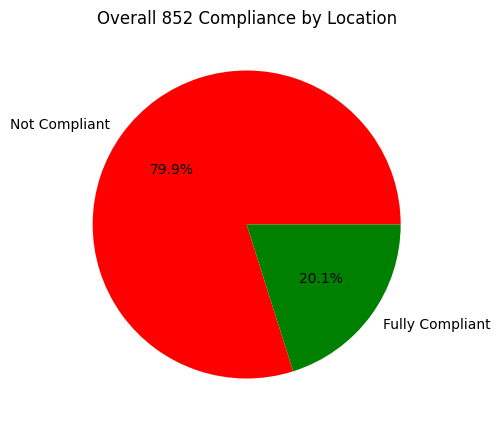

✅ Location-wise compliance report saved to: /content/Location_Wise_Compliance.xlsx (including Overall per type)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
in_path = "/content/Data Received Details.xlsx"
df = pd.read_excel(in_path)
df.columns = df.columns.str.strip()

# Helper: convert various formats to numeric 0-100
def to_numeric_percent(x):
    if pd.isna(x):
        return 0.0
    s = str(x).strip().lower()
    if s in ('yes','y','true','t'):
        return 100.0
    if s in ('no','n','false','f'):
        return 0.0
    if '%' in s:
        try:
            return max(0.0, min(100.0, float(s.replace('%','').strip())))
        except:
            return 0.0
    try:
        v = float(s)
        if 0 <= v <= 1:
            return v * 100
        return max(0.0, min(100.0, v))
    except:
        pass
    try:
        pd.to_datetime(s)
        return 100.0
    except:
        return 0.0

# Columns
col_846 = 'Inventory Data Received (846)'
col_856 = 'Ship Data Received (856)'
col_852_plan = 'Production Plan Data Received (852)'
col_852_act = 'Production Actual Data Received (852)'

# Convert to numeric
df['_846_num'] = df[col_846].apply(to_numeric_percent)
df['_856_num'] = df[col_856].apply(to_numeric_percent)
df['_852_avg'] = (df[col_852_plan].apply(to_numeric_percent) + df[col_852_act].apply(to_numeric_percent))/2

# Compliance function (detailed)
def compliance_level(x):
    if x == 0:
        return "Not compliant"
    elif 0 < x < 75:
        return "Average performance"
    elif 75 <= x < 100:
        return "Good performance"
    elif x == 100:
        return "Fully compliant"
    else:
        return "Unknown"

# Aggregate by Location
location_summary = df.groupby('Location').agg({
    '_846_num':'mean',
    '_856_num':'mean',
    '_852_avg':'mean'
}).reset_index()

# Individual compliance levels
location_summary['846_Compliance'] = location_summary['_846_num'].apply(compliance_level)
location_summary['856_Compliance'] = location_summary['_856_num'].apply(compliance_level)
location_summary['852_Compliance'] = location_summary['_852_avg'].apply(compliance_level)

# Function to plot pie chart
def plot_pie(series, title):
    counts = series.value_counts()
    colors = {'Not compliant':'red','Average performance':'orange','Good performance':'yellow','Fully compliant':'green',
              'Not Compliant':'red','Fully Compliant':'green'}
    plt.figure(figsize=(5,5))
    plt.pie([counts.get(k,0) for k in counts.index],
            labels=counts.index,
            autopct='%1.1f%%',
            colors=[colors.get(k,'grey') for k in counts.index])
    plt.title(title)
    plt.show()

# Plot pie charts
plot_pie(location_summary['846_Compliance'], 'Inventory Compliance (846) by Location')
plot_pie(location_summary['856_Compliance'], 'Ship Compliance (856) by Location')
plot_pie(location_summary['852_Compliance'], 'Production Compliance (852) by Location')

# ---------- Overall simplified compliance per type ----------
def simple_compliance(x):
    if x == 0:
        return "Not Compliant"
    else:
        return "Fully Compliant"

location_summary['846_Simple'] = location_summary['_846_num'].apply(simple_compliance)
location_summary['856_Simple'] = location_summary['_856_num'].apply(simple_compliance)
location_summary['852_Simple'] = location_summary['_852_avg'].apply(simple_compliance)

# Plot overall simplified pie charts per type
plot_pie(location_summary['846_Simple'], 'Overall 846 Compliance by Location')
plot_pie(location_summary['856_Simple'], 'Overall 856 Compliance by Location')
plot_pie(location_summary['852_Simple'], 'Overall 852 Compliance by Location')

# ---------- Export to Excel ----------
output_path = "/content/Location_Wise_Compliance.xlsx"
with pd.ExcelWriter(output_path) as writer:
    # Full location summary
    location_summary.to_excel(writer, sheet_name='Location_Summary', index=False)

    # Individual summaries (detailed)
    pd.DataFrame(location_summary['846_Compliance'].value_counts()).reset_index().to_excel(writer, sheet_name='846_Summary', index=False)
    pd.DataFrame(location_summary['856_Compliance'].value_counts()).reset_index().to_excel(writer, sheet_name='856_Summary', index=False)
    pd.DataFrame(location_summary['852_Compliance'].value_counts()).reset_index().to_excel(writer, sheet_name='852_Summary', index=False)

    # Overall simplified summary per type
    pd.DataFrame(location_summary['846_Simple'].value_counts()).reset_index().to_excel(writer, sheet_name='846_Overall', index=False)
    pd.DataFrame(location_summary['856_Simple'].value_counts()).reset_index().to_excel(writer, sheet_name='856_Overall', index=False)
    pd.DataFrame(location_summary['852_Simple'].value_counts()).reset_index().to_excel(writer, sheet_name='852_Overall', index=False)

print(f"✅ Location-wise compliance report saved to: {output_path} (including Overall per type)")
